In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/AAXJ2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,61.439999,61.939999,61.340000,61.759998,53.829903,520200
1,1/3/2013,61.320000,61.660000,61.230000,61.290001,53.420250,416900
2,1/4/2013,61.060001,61.330002,60.950001,61.290001,53.420250,296400
3,1/7/2013,60.880001,60.880001,60.639999,60.810001,53.001884,249900
4,1/8/2013,60.590000,60.599998,60.119999,60.299999,52.557358,219100


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -64.550022.3, cost: 0.055267, total money: 9862.189976
epoch: 20, total rewards: 12.259895.3, cost: 0.003144, total money: 10012.259895
epoch: 30, total rewards: -48.289990.3, cost: 0.012065, total money: 9586.220020
epoch: 40, total rewards: 22.960087.3, cost: 0.003322, total money: 10022.960087
epoch: 50, total rewards: -6.569939.3, cost: 0.002053, total money: 9637.800064
epoch: 60, total rewards: -46.209938.3, cost: 0.000636, total money: 9515.910065
epoch: 70, total rewards: 97.809979.3, cost: 0.006862, total money: 10024.549976
epoch: 80, total rewards: -66.879963.3, cost: 0.000600, total money: 9787.090038
epoch: 90, total rewards: 60.459946.3, cost: 0.079040, total money: 8735.799942
epoch: 100, total rewards: -5.800007.3, cost: 0.001571, total money: 9921.389996
epoch: 110, tot

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 61.060001, total balance 9938.939999
day 12, sell 1 unit at price 61.060001, investment 0.000000 %, total balance 10000.000000,
day 19: buy 1 unit at price 60.630001, total balance 9939.369999
day 20, sell 1 unit at price 60.470001, investment -0.263896 %, total balance 9999.840000,
day 24: buy 1 unit at price 60.099998, total balance 9939.740002
day 26, sell 1 unit at price 60.130001, investment 0.049921 %, total balance 9999.870003,
day 30: buy 1 unit at price 60.740002, total balance 9939.130001
day 31, sell 1 unit at price 60.630001, investment -0.181101 %, total balance 9999.760002,
day 34: buy 1 unit at price 59.790001, total balance 9939.970001
day 35: buy 1 unit at price 59.950001, total balance 9880.020000
day 36, sell 1 unit at price 59.160000, investment -1.053690 %, total balance 9939.180000,
day 37, sell 1 unit at price 59.369999, investment -0.967476 %, total balance 9998.549999,
day 38: buy 1 unit at price 60.180000, total balance 9938.369999


day 377, sell 1 unit at price 63.830002, investment 1.818477 %, total balance 9949.040024,
day 378, sell 1 unit at price 64.080002, investment 1.360330 %, total balance 10013.120026,
day 396: buy 1 unit at price 65.550003, total balance 9947.570023
day 397, sell 1 unit at price 64.489998, investment -1.617094 %, total balance 10012.060020,
day 402: buy 1 unit at price 63.950001, total balance 9948.110020
day 403, sell 1 unit at price 64.349998, investment 0.625485 %, total balance 10012.460018,
day 410: buy 1 unit at price 66.080002, total balance 9946.380016
day 411, sell 1 unit at price 66.050003, investment -0.045398 %, total balance 10012.430019,
day 417: buy 1 unit at price 65.699997, total balance 9946.730022
day 418, sell 1 unit at price 65.720001, investment 0.030448 %, total balance 10012.450024,
day 420: buy 1 unit at price 66.230003, total balance 9946.220020
day 421, sell 1 unit at price 66.379997, investment 0.226474 %, total balance 10012.600017,
day 426: buy 1 unit at pr

day 933, sell 1 unit at price 59.639999, investment 2.263374 %, total balance 10008.460026,
day 936: buy 1 unit at price 59.720001, total balance 9948.740024
day 937, sell 1 unit at price 61.209999, investment 2.494973 %, total balance 10009.950024,
day 942: buy 1 unit at price 61.099998, total balance 9948.850025
day 943, sell 1 unit at price 60.209999, investment -1.456628 %, total balance 10009.060024,
day 963: buy 1 unit at price 59.119999, total balance 9949.940025
day 965, sell 1 unit at price 58.919998, investment -0.338296 %, total balance 10008.860023,
day 969: buy 1 unit at price 57.639999, total balance 9951.220024
day 971, sell 1 unit at price 59.389999, investment 3.036086 %, total balance 10010.610023,
day 973: buy 1 unit at price 56.720001, total balance 9953.890022
day 974, sell 1 unit at price 55.730000, investment -1.745419 %, total balance 10009.620022,
day 979: buy 1 unit at price 55.750000, total balance 9953.870022
day 980: buy 1 unit at price 55.910000, total bal

day 1421, sell 1 unit at price 70.500000, investment -1.246672 %, total balance 10021.750034,
day 1428: buy 1 unit at price 70.599998, total balance 9951.150036
day 1429, sell 1 unit at price 69.379997, investment -1.728047 %, total balance 10020.530033,
day 1435: buy 1 unit at price 69.660004, total balance 9950.870029
day 1436, sell 1 unit at price 69.589996, investment -0.100499 %, total balance 10020.460026,
day 1439: buy 1 unit at price 70.300003, total balance 9950.160023
day 1440, sell 1 unit at price 70.949997, investment 0.924600 %, total balance 10021.110020,
day 1447: buy 1 unit at price 70.459999, total balance 9950.650021
day 1448, sell 1 unit at price 69.250000, investment -1.717285 %, total balance 10019.900021,
day 1454: buy 1 unit at price 63.900002, total balance 9956.000019
day 1455, sell 1 unit at price 63.259998, investment -1.001570 %, total balance 10019.260017,
day 1457: buy 1 unit at price 64.110001, total balance 9955.150017
day 1458, sell 1 unit at price 65.5

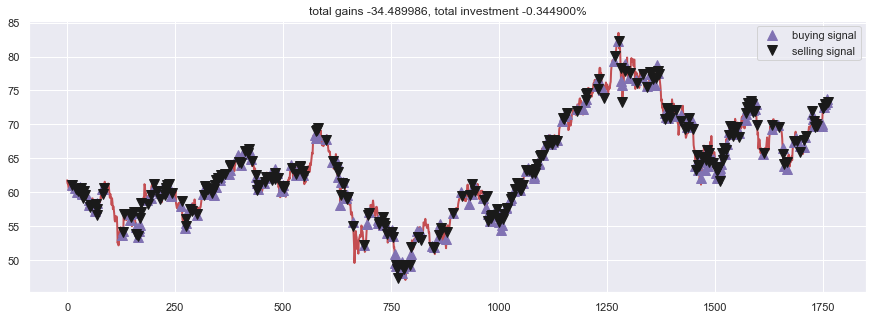

In [9]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()